In [1]:
# [1] Load Preprocessed Torch Datasets

import os
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset_dir = "torch_datasets"
train_dataset_path = os.path.join(dataset_dir, "train_dataset.pt")
test_dataset_path  = os.path.join(dataset_dir, "test_dataset.pt")

train_dataset: TensorDataset = torch.load(
    train_dataset_path,
    map_location="cpu",
    weights_only=False,
)
test_dataset: TensorDataset = torch.load(
    test_dataset_path,
    map_location="cpu",
    weights_only=False,
)

print("Loaded train dataset:", train_dataset_path)
print("Loaded test  dataset:", test_dataset_path)


Using device: cuda
Loaded train dataset: torch_datasets\train_dataset.pt
Loaded test  dataset: torch_datasets\test_dataset.pt


In [2]:
# [2] Inspect Dataset Structure

X_train, y_train = train_dataset.tensors
X_test,  y_test  = test_dataset.tensors

print("X_train:", X_train.shape, X_train.dtype, X_train.device)
print("y_train:", y_train.shape, y_train.dtype, y_train.device)
print("X_test :", X_test.shape,  X_test.dtype,  X_test.device)
print("y_test :", y_test.shape,  y_test.dtype,  y_test.device)

print("Label counts (train):", torch.bincount(y_train).tolist())
print("Label counts (test) :", torch.bincount(y_test).tolist())


X_train: torch.Size([4665, 1, 22, 1001]) torch.float32 cpu
y_train: torch.Size([4665]) torch.int64 cpu
X_test : torch.Size([519, 1, 22, 1001]) torch.float32 cpu
y_test : torch.Size([519]) torch.int64 cpu
Label counts (train): [1166, 1167, 1166, 1166]
Label counts (test) : [130, 129, 130, 130]


In [3]:
# [3] Create DataLoaders

batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda"),
)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))


Train batches: 73
Test  batches: 9


In [4]:
# [4] MI-9 Channel Selection + Conditioning Functions

import numpy as np
from torch import nn

target_22 = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4",
    "C5", "C3", "C1", "Cz", "C2", "C4",
    "C6", "CP3", "CP1", "CPz", "CP2", "CP4",
    "P1", "Pz", "P2", "POz"
]

mi9_channels = ["FC1", "FCz", "FC2", "C3", "Cz", "C4", "CP1", "CPz", "CP2"]
keep_idx_list = [target_22.index(ch) for ch in mi9_channels]
keep_idx = torch.tensor(keep_idx_list, dtype=torch.long)

print("MI-9 keep_idx:", keep_idx_list)

def make_condition(x):
    idx = keep_idx.to(x.device)
    x_cond_full = torch.zeros_like(x)
    x_cond_full[:, idx, :] = x[:, idx, :]
    mask = torch.zeros_like(x)
    mask[:, idx, :] = 1.0
    return x_cond_full, mask

def make_condition_from_observation(x_obs):
    return make_condition(x_obs)


MI-9 keep_idx: [2, 3, 4, 7, 9, 11, 14, 15, 16]


In [5]:
# [5] DDPM Schedule + Forward Diffusion

def make_beta_schedule(T, beta_start=1e-4, beta_end=0.02, device=device):
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    return betas, alphas, alphas_bar

T_diffusion = 200
betas, alphas, alphas_bar = make_beta_schedule(T_diffusion)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = alphas_bar[t].view(-1, 1, 1)
    x_t = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * noise
    return x_t, noise


In [6]:
# [6] Time Embedding + Length-Preserving 1D Denoiser

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half = self.dim // 2
        freq = torch.exp(torch.linspace(np.log(1.0), np.log(10000.0), half, device=t.device))
        args = t.float().unsqueeze(1) / freq.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb

class ResidualBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(t_emb_dim, out_ch)
        self.act = nn.SiLU()
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = h + self.time_mlp(t_emb).unsqueeze(-1)
        h = self.act(h)
        h = self.conv2(h)
        return self.act(h + self.skip(x))

class UNet1D(nn.Module):  # 실질적으로 length-preserving ResNet
    def __init__(self, in_ch=66, base_ch=64, t_emb_dim=128):
        super().__init__()
        self.time_emb = SinusoidalTimeEmbedding(t_emb_dim)

        self.block1 = ResidualBlock1D(in_ch,     base_ch,     t_emb_dim)
        self.block2 = ResidualBlock1D(base_ch,   base_ch * 2, t_emb_dim)
        self.block3 = ResidualBlock1D(base_ch*2, base_ch * 2, t_emb_dim)
        self.block4 = ResidualBlock1D(base_ch*2, base_ch,     t_emb_dim)
        self.block5 = ResidualBlock1D(base_ch,   base_ch,     t_emb_dim)

        self.out_conv = nn.Conv1d(base_ch, 22, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        h1 = self.block1(x,  t_emb)
        h2 = self.block2(h1, t_emb)
        h3 = self.block3(h2, t_emb)
        h4 = self.block4(h3, t_emb)
        h5 = self.block5(h4, t_emb)
        return self.out_conv(h5)

model = UNet1D(in_ch=66).to(device)
print("Model params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


Model params (M): 0.339414


In [7]:
# [7] DDPM Training Loop

import torch.nn.functional as F
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 50

def sample_timesteps(batch_size, T):
    return torch.randint(0, T, (batch_size,), device=device)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        X_batch = X_batch.to(device).squeeze(1)
        B, C, Tlen = X_batch.shape

        x0 = X_batch
        x_cond, mask = make_condition(x0)
        t = sample_timesteps(B, T_diffusion)
        x_t, noise = q_sample(x0, t)

        model_in = torch.cat([x_t, x_cond, mask], dim=1)
        noise_pred = model(model_in, t)

        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * B

    print(f"Epoch {epoch+1} | Loss: {epoch_loss / len(train_dataset):.6f}")


Epoch 1/50: 100%|██████████| 73/73 [00:02<00:00, 26.03it/s]


Epoch 1 | Loss: 0.972048


Epoch 2/50: 100%|██████████| 73/73 [00:02<00:00, 30.26it/s]


Epoch 2 | Loss: 0.732778


Epoch 3/50: 100%|██████████| 73/73 [00:02<00:00, 30.44it/s]


Epoch 3 | Loss: 0.567712


Epoch 4/50: 100%|██████████| 73/73 [00:02<00:00, 30.23it/s]


Epoch 4 | Loss: 0.461615


Epoch 5/50: 100%|██████████| 73/73 [00:02<00:00, 30.17it/s]


Epoch 5 | Loss: 0.382635


Epoch 6/50: 100%|██████████| 73/73 [00:02<00:00, 30.20it/s]


Epoch 6 | Loss: 0.322784


Epoch 7/50: 100%|██████████| 73/73 [00:02<00:00, 30.20it/s]


Epoch 7 | Loss: 0.285953


Epoch 8/50: 100%|██████████| 73/73 [00:02<00:00, 30.51it/s]


Epoch 8 | Loss: 0.245035


Epoch 9/50: 100%|██████████| 73/73 [00:02<00:00, 30.10it/s]


Epoch 9 | Loss: 0.220215


Epoch 10/50: 100%|██████████| 73/73 [00:02<00:00, 30.06it/s]


Epoch 10 | Loss: 0.201270


Epoch 11/50: 100%|██████████| 73/73 [00:02<00:00, 30.00it/s]


Epoch 11 | Loss: 0.188134


Epoch 12/50: 100%|██████████| 73/73 [00:02<00:00, 30.16it/s]


Epoch 12 | Loss: 0.174155


Epoch 13/50: 100%|██████████| 73/73 [00:02<00:00, 30.10it/s]


Epoch 13 | Loss: 0.171143


Epoch 14/50: 100%|██████████| 73/73 [00:02<00:00, 30.21it/s]


Epoch 14 | Loss: 0.163386


Epoch 15/50: 100%|██████████| 73/73 [00:02<00:00, 30.36it/s]


Epoch 15 | Loss: 0.155258


Epoch 16/50: 100%|██████████| 73/73 [00:02<00:00, 30.43it/s]


Epoch 16 | Loss: 0.144987


Epoch 17/50: 100%|██████████| 73/73 [00:02<00:00, 30.24it/s]


Epoch 17 | Loss: 0.154137


Epoch 18/50: 100%|██████████| 73/73 [00:02<00:00, 30.17it/s]


Epoch 18 | Loss: 0.135749


Epoch 19/50: 100%|██████████| 73/73 [00:02<00:00, 30.34it/s]


Epoch 19 | Loss: 0.136409


Epoch 20/50: 100%|██████████| 73/73 [00:02<00:00, 30.32it/s]


Epoch 20 | Loss: 0.138637


Epoch 21/50: 100%|██████████| 73/73 [00:02<00:00, 30.18it/s]


Epoch 21 | Loss: 0.132153


Epoch 22/50: 100%|██████████| 73/73 [00:02<00:00, 30.21it/s]


Epoch 22 | Loss: 0.127431


Epoch 23/50: 100%|██████████| 73/73 [00:02<00:00, 30.40it/s]


Epoch 23 | Loss: 0.133662


Epoch 24/50: 100%|██████████| 73/73 [00:02<00:00, 30.21it/s]


Epoch 24 | Loss: 0.126969


Epoch 25/50: 100%|██████████| 73/73 [00:02<00:00, 30.35it/s]


Epoch 25 | Loss: 0.122770


Epoch 26/50: 100%|██████████| 73/73 [00:02<00:00, 30.07it/s]


Epoch 26 | Loss: 0.118893


Epoch 27/50: 100%|██████████| 73/73 [00:02<00:00, 30.20it/s]


Epoch 27 | Loss: 0.117706


Epoch 28/50: 100%|██████████| 73/73 [00:02<00:00, 30.21it/s]


Epoch 28 | Loss: 0.114946


Epoch 29/50: 100%|██████████| 73/73 [00:02<00:00, 30.41it/s]


Epoch 29 | Loss: 0.119226


Epoch 30/50: 100%|██████████| 73/73 [00:02<00:00, 30.64it/s]


Epoch 30 | Loss: 0.111692


Epoch 31/50: 100%|██████████| 73/73 [00:02<00:00, 30.43it/s]


Epoch 31 | Loss: 0.110516


Epoch 32/50: 100%|██████████| 73/73 [00:02<00:00, 29.10it/s]


Epoch 32 | Loss: 0.112514


Epoch 33/50: 100%|██████████| 73/73 [00:02<00:00, 28.80it/s]


Epoch 33 | Loss: 0.110262


Epoch 34/50: 100%|██████████| 73/73 [00:02<00:00, 29.08it/s]


Epoch 34 | Loss: 0.101334


Epoch 35/50: 100%|██████████| 73/73 [00:02<00:00, 28.85it/s]


Epoch 35 | Loss: 0.105648


Epoch 36/50: 100%|██████████| 73/73 [00:02<00:00, 28.08it/s]


Epoch 36 | Loss: 0.105339


Epoch 37/50: 100%|██████████| 73/73 [00:02<00:00, 28.08it/s]


Epoch 37 | Loss: 0.104921


Epoch 38/50: 100%|██████████| 73/73 [00:02<00:00, 28.08it/s]


Epoch 38 | Loss: 0.103408


Epoch 39/50: 100%|██████████| 73/73 [00:02<00:00, 28.50it/s]


Epoch 39 | Loss: 0.098596


Epoch 40/50: 100%|██████████| 73/73 [00:02<00:00, 28.91it/s]


Epoch 40 | Loss: 0.101646


Epoch 41/50: 100%|██████████| 73/73 [00:02<00:00, 28.16it/s]


Epoch 41 | Loss: 0.101050


Epoch 42/50: 100%|██████████| 73/73 [00:02<00:00, 27.70it/s]


Epoch 42 | Loss: 0.100936


Epoch 43/50: 100%|██████████| 73/73 [00:02<00:00, 28.15it/s]


Epoch 43 | Loss: 0.097144


Epoch 44/50: 100%|██████████| 73/73 [00:02<00:00, 27.74it/s]


Epoch 44 | Loss: 0.099110


Epoch 45/50: 100%|██████████| 73/73 [00:02<00:00, 28.26it/s]


Epoch 45 | Loss: 0.097104


Epoch 46/50: 100%|██████████| 73/73 [00:02<00:00, 26.50it/s]


Epoch 46 | Loss: 0.095012


Epoch 47/50: 100%|██████████| 73/73 [00:02<00:00, 28.14it/s]


Epoch 47 | Loss: 0.093576


Epoch 48/50: 100%|██████████| 73/73 [00:02<00:00, 28.82it/s]


Epoch 48 | Loss: 0.094735


Epoch 49/50: 100%|██████████| 73/73 [00:02<00:00, 28.66it/s]


Epoch 49 | Loss: 0.093296


Epoch 50/50: 100%|██████████| 73/73 [00:02<00:00, 29.03it/s]

Epoch 50 | Loss: 0.096803


In [8]:
# [8] Reverse Diffusion (MI-9 → Full 22 채널 복원)

@torch.no_grad()
def p_sample_step(x_t, t, model, x_cond, mask):
    noise_pred = model(torch.cat([x_t, x_cond, mask], dim=1), t)
    beta = betas[t].view(-1, 1, 1)
    alpha = alphas[t].view(-1, 1, 1)
    alpha_bar = alphas_bar[t].view(-1, 1, 1)

    mean = (1 / alpha.sqrt()) * (x_t - beta / (1 - alpha_bar).sqrt() * noise_pred)
    noise = torch.randn_like(x_t) if (t > 0).any() else torch.zeros_like(x_t)
    return mean + beta.sqrt() * noise

@torch.no_grad()
def reconstruct_full_from_9(x_obs, model):
    x_obs = x_obs.to(device)
    x_cond, mask = make_condition_from_observation(x_obs)
    B, C, Tlen = x_obs.shape

    x_t = torch.randn_like(x_obs)
    idx = keep_idx.to(device)

    for step in reversed(range(T_diffusion)):
        t = torch.full((B,), step, device=device, dtype=torch.long)
        x_t = p_sample_step(x_t, t, model, x_cond, mask)
        x_t[:, idx, :] = x_obs[:, idx, :]

    return x_t

X_test_batch, _ = next(iter(test_loader))
X_test_batch = X_test_batch.to(device).squeeze(1)

x_obs = torch.zeros_like(X_test_batch)
idx = keep_idx.to(device)
x_obs[:, idx, :] = X_test_batch[:, idx, :]

x_recon = reconstruct_full_from_9(x_obs, model)

print("x_obs:", x_obs.shape, "x_recon:", x_recon.shape)


x_obs: torch.Size([64, 22, 1001]) x_recon: torch.Size([64, 22, 1001])


=== Reconstruction Metrics ===
Overall     MSE : 0.057773
Overall     Corr: 0.9656
MI-9        MSE : 0.000000
MI-9        Corr: 1.0000
Missing 13  MSE : 0.097770
Missing 13  Corr: 0.9418
MSE per channel: [0.05580644682049751, 0.04157114401459694, 0.0, 0.0, 0.0, 0.04163692891597748, 0.11142560839653015, 0.0, 0.013361537829041481, 0.0, 0.01584933139383793, 0.0, 0.1315624713897705, 0.039129987359046936, 0.0, 0.0, 0.0, 0.02706042490899563, 0.1095622107386589, 0.08601626753807068, 0.11591427028179169, 0.48210978507995605]
Corr per channel: [0.9691731333732605, 0.9734665155410767, 1.0, 0.9999999403953552, 1.0000001192092896, 0.9766901135444641, 0.8920470476150513, 0.9999999403953552, 0.9924584627151489, 1.0, 0.9919186234474182, 1.0, 0.9138139486312866, 0.9757843017578125, 1.0, 1.0000001192092896, 1.0000001192092896, 0.986792802810669, 0.9398376941680908, 0.9595404267311096, 0.943368136882782, 0.7279016375541687]


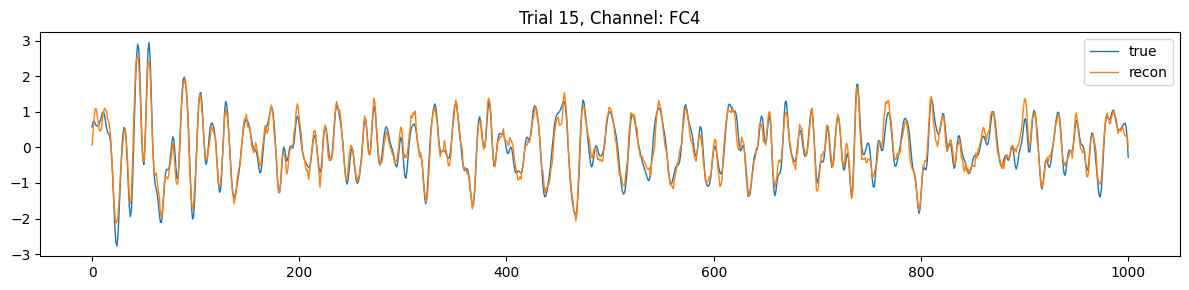

In [ ]:
# [9] Reconstruction + evaluation (single cell)

import torch
import matplotlib.pyplot as plt

try:
    from scipy.signal import welch
    _has_scipy = True
except ImportError:
    _has_scipy = False

# 0) 한 배치 가져와서 복원 수행
X_test_batch, _ = next(iter(test_loader))        # [B,1,22,1001]
x_test_batch = X_test_batch.to(device).squeeze(1)  # [B,22,1001]

x_obs = torch.zeros_like(x_test_batch)           # MI-9만 남긴 관측
idx = keep_idx.to(device)
x_obs[:, idx, :] = x_test_batch[:, idx, :]

x_recon = reconstruct_full_from_9(x_obs, model)  # [B,22,1001]


# 1) Metrics 계산

def mse_per_channel(x_true, x_recon):
    # x_*: [B,22,T] → [22]
    return ((x_true - x_recon) ** 2).mean(dim=-1).mean(dim=0).cpu()

def corr_per_channel(x_true, x_recon):
    # x_*: [B,22,T] → list[22]
    B, C, T = x_true.shape
    corr = []
    for c in range(C):
        a = x_true[:, c, :].reshape(B * T)
        b = x_recon[:, c, :].reshape(B * T)
        a = a - a.mean()
        b = b - b.mean()
        num = (a * b).sum()
        den = a.norm() * b.norm() + 1e-8
        corr.append((num / den).item())
    return corr

mse_ch  = mse_per_channel(x_test_batch, x_recon)   # tensor[22]
corr_ch = corr_per_channel(x_test_batch, x_recon)  # list[22]

all_idx     = list(range(22))
missing_idx = sorted(list(set(all_idx) - set(keep_idx_list)))

overall_mse  = mse_ch.mean().item()
overall_corr = sum(corr_ch) / len(corr_ch)
mi9_mse      = mse_ch[keep_idx_list].mean().item()
mi9_corr     = sum(corr_ch[i] for i in keep_idx_list) / len(keep_idx_list)
missing_mse  = mse_ch[missing_idx].mean().item()
missing_corr = sum(corr_ch[i] for i in missing_idx) / len(missing_idx)

print("=== Reconstruction Metrics ===")
print(f"Overall     MSE : {overall_mse:.6f}")
print(f"Overall     Corr: {overall_corr:.4f}")
print(f"MI-9        MSE : {mi9_mse:.6f}")
print(f"MI-9        Corr: {mi9_corr:.4f}")
print(f"Missing 13  MSE : {missing_mse:.6f}")
print(f"Missing 13  Corr: {missing_corr:.4f}")
print("MSE per channel:", mse_ch.tolist())
print("Corr per channel:", corr_ch)


# 2) 시간 파형 비교 플롯

def plot_compare(trial_idx=0, ch_idx=4):
    """
    trial_idx: 배치 내 trial index
    ch_idx   : 0~21 (target_22 기준)
    """
    true_sig = x_test_batch[trial_idx, ch_idx].detach().cpu()
    rec_sig  = x_recon[trial_idx, ch_idx].detach().cpu()

    plt.figure(figsize=(12, 3))
    plt.plot(true_sig, label="true", linewidth=1)
    plt.plot(rec_sig, label="recon", linewidth=1)
    plt.title(f"Trial {trial_idx}, Channel: {target_22[ch_idx]}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3) PSD 비교 플롯

def compare_psd(trial_idx=0, ch_idx=20, fs=250):
    if not _has_scipy:
        print("scipy 없음 → PSD 비교 생략 (pip install scipy 필요).")
        return

    true_sig = x_test_batch[trial_idx, ch_idx].detach().cpu()
    rec_sig  = x_recon[trial_idx, ch_idx].detach().cpu()

    f1, Pxx_true = welch(true_sig, fs=fs, nperseg=512)
    f2, Pxx_rec  = welch(rec_sig,  fs=fs, nperseg=512)

    plt.figure(figsize=(12, 3))
    plt.semilogy(f1, Pxx_true, label='true')
    plt.semilogy(f2, Pxx_rec,  label='recon')
    plt.title(f"PSD Comparison | Ch: {target_22[ch_idx]}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 4) 예시 호출 
plot_compare(trial_idx=15, ch_idx=5) 



In [ ]:
# [10] Save DDPM model (state_dict)

import json
from pathlib import Path

# 0) 체크포인트 디렉토리 설정
ckpt_dir = Path("checkpoints_mi9_ddpm")
ckpt_dir.mkdir(parents=True, exist_ok=True)

state_path  = ckpt_dir / "ddpm_mi9_state_dict.pth"
config_path = ckpt_dir / "config.json"

# 1) DDPM 노이즈 예측기 state_dict 저장
torch.save(model.state_dict(), state_path)

# 2) ROS2 / 외부 스크립트에서 필요할 최소 설정값 저장
config = {
    "T_diffusion": int(T_diffusion),
    "input_channels": 22,
    "mi9_channels": mi9_channels,          # 채널 이름
    "mi9_indices": keep_idx_list,          # 22채널 기준 index
    "target_22": target_22,                # 전체 채널 이름
    "model_args": {
        "in_ch": 66,                       # x_t(22) + x_cond(22) + mask(22)
        "base_ch": 64,
        "t_emb_dim": 128,
        "out_ch": 22
    }
}

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

print("Saved DDPM state_dict to:", state_path)
print("Saved config to       :", config_path)



Saved DDPM state_dict to: checkpoints_mi9_ddpm\ddpm_mi9_state_dict.pth
Saved config to       : checkpoints_mi9_ddpm\config.json


In [11]:
# [11] Create MI-9 masked & DDPM-recovered datasets and save (train / test)

@torch.no_grad()
def process_dataset(dataset, model, batch_size=32):
    """
    Input : TensorDataset([N,1,22,T], y)
    Output: masked_dataset, recovered_dataset (TensorDataset)
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    X_masked_all = []
    X_recovered_all = []
    y_all = []

    idx = keep_idx.to(device)

    for X, y in loader:
        X = X.to(device).squeeze(1)  # [B,22,T]
        y_all.append(y)

        # MI-9 masked observation
        x_obs = torch.zeros_like(X)
        x_obs[:, idx, :] = X[:, idx, :]
        X_masked_all.append(x_obs.cpu())

        # DDPM reconstruction
        x_rec = reconstruct_full_from_9(x_obs, model)
        X_recovered_all.append(x_rec.cpu())

    X_masked_all    = torch.cat(X_masked_all, dim=0).unsqueeze(1)
    X_recovered_all = torch.cat(X_recovered_all, dim=0).unsqueeze(1)
    y_all           = torch.cat(y_all, dim=0)

    return (
        TensorDataset(X_masked_all, y_all),
        TensorDataset(X_recovered_all, y_all),
    )


# --- Run processing ---
model.eval()

train_masked_ds, train_recovered_ds = process_dataset(train_dataset, model, batch_size=32)
test_masked_ds,  test_recovered_ds  = process_dataset(test_dataset,  model, batch_size=32)

print("Train masked    :", train_masked_ds.tensors[0].shape)
print("Train recovered :", train_recovered_ds.tensors[0].shape)
print("Test masked     :", test_masked_ds.tensors[0].shape)
print("Test recovered  :", test_recovered_ds.tensors[0].shape)


# --- Save to torch_datasets ---
save_dir = "torch_datasets"
os.makedirs(save_dir, exist_ok=True)

torch.save(train_masked_ds,    os.path.join(save_dir, "train_dataset_masked.pt"))
torch.save(test_masked_ds,     os.path.join(save_dir, "test_dataset_masked.pt"))
torch.save(train_recovered_ds, os.path.join(save_dir, "train_dataset_recovered.pt"))
torch.save(test_recovered_ds,  os.path.join(save_dir, "test_dataset_recovered.pt"))

print("Saved datasets:")
print(" - train_dataset_masked.pt")
print(" - test_dataset_masked.pt")
print(" - train_dataset_recovered.pt")
print(" - test_dataset_recovered.pt")


Train masked    : torch.Size([4665, 1, 22, 1001])
Train recovered : torch.Size([4665, 1, 22, 1001])
Test masked     : torch.Size([519, 1, 22, 1001])
Test recovered  : torch.Size([519, 1, 22, 1001])
Saved datasets:
 - train_dataset_masked.pt
 - test_dataset_masked.pt
 - train_dataset_recovered.pt
 - test_dataset_recovered.pt
